# 3.b Model Development (Open)

In [17]:
import numpy as np
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import boto3 
import io  
from sagemaker import get_execution_role
role = get_execution_role()
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [18]:
role

'arn:aws:iam::190183093544:role/service-role/AmazonSageMaker-ExecutionRole-20220602T141236'

In [19]:
session = boto3.Session()

### Load the Data from S3

In [20]:
bucket='data-aman-use-case'  
file_key = 'x_train_open.npy' 
  
s3_client = boto3.client('s3')  
obj = s3_client.get_object(Bucket=bucket, Key=file_key)  
x_train_open = np.load(io.BytesIO(obj['Body'].read()))  

In [21]:
bucket='data-aman-use-case'  
file_key = 'x_test_open.npy' 
  
s3_client = boto3.client('s3')  
obj = s3_client.get_object(Bucket=bucket, Key=file_key)  
x_test_open = np.load(io.BytesIO(obj['Body'].read()))  

In [22]:
bucket='data-aman-use-case'  
file_key = 'y_train_open.npy' 
  
s3_client = boto3.client('s3')  
obj = s3_client.get_object(Bucket=bucket, Key=file_key)  
y_train_open = np.load(io.BytesIO(obj['Body'].read()))  

In [23]:
bucket='data-aman-use-case'  
file_key = 'y_test_open.npy' 
  
s3_client = boto3.client('s3')  
obj = s3_client.get_object(Bucket=bucket, Key=file_key)  
y_test_open = np.load(io.BytesIO(obj['Body'].read()))  

### Building the LSTM RNN Model

In [24]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train_open.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 100)           40800     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train_open, y_train_open, batch_size= 1, epochs=20)

Epoch 1/20
2216/2216 [==============================] - 87s 39ms/step - loss: 1.9947e-04
Epoch 2/20
2216/2216 [==============================] - 86s 39ms/step - loss: 8.8718e-05
Epoch 3/20
2216/2216 [==============================] - 88s 40ms/step - loss: 7.8665e-05
Epoch 4/20
2216/2216 [==============================] - 87s 39ms/step - loss: 5.5642e-05
Epoch 5/20
2216/2216 [==============================] - 89s 40ms/step - loss: 6.4416e-05
Epoch 6/20
2216/2216 [==============================] - 90s 41ms/step - loss: 6.3891e-05
Epoch 7/20
2216/2216 [==============================] - 89s 40ms/step - loss: 4.7844e-05
Epoch 8/20
2216/2216 [==============================] - 92s 42ms/step - loss: 4.4583e-05
Epoch 9/20
2216/2216 [==============================] - 90s 40ms/step - loss: 5.0412e-05
Epoch 10/20
2216/2216 [==============================] - 89s 40ms/step - loss: 4.7948e-05
Epoch 11/20
2216/2216 [==============================] - 88s 40ms/step - loss: 4.2996e-05
Epoch 12/20
2216/22

In [11]:
predictions = model.predict(x_test_open)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test_open)**2)
rmse

28502.28568199146

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


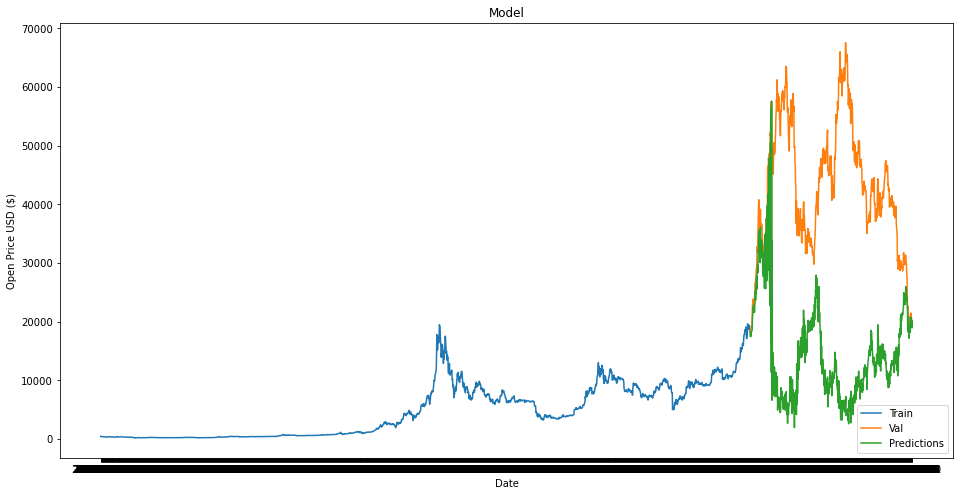

In [12]:
data = data.filter(['Open'])
train = data[:training_data_len_open]
validation = data[training_data_len_open:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Open Price USD ($)')
plt.plot(train)
plt.plot(validation[['Open', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()